In [1]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3

3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:38:57) [GCC 10.3.0]
pjr3.py complete


In [2]:
hy2plev?

Signature: hy2plev(T, P, pout, verbose=False)
Docstring:
hy2plev(T, P, pout)
interpolate a field from hybrid to pressure coordinates
    assumes the input fields are xarray dataarrays
    tested for EAM/CAM cubed sphere and lat/lon grids
    
       T the array on hybrid surfaces
       P the pressures on hybrid surfaces 
       pout the pressures to interpolate to (array or scalar)
File:      ~/Python/pjr3.py
Type:      function


plotting  <xarray.DataArray (ncol: 21600)>
array([285.35014074, 284.80348245, 286.31016305, ..., 264.18005051,
       264.78022066, 265.25982283])
Coordinates:
    time     object 0001-02-01 00:00:00
    plev     float64 850.0
Dimensions without coordinates: ncol
Attributes:
    mdims:          1
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
    cell_methods:   time: mean
plotfile test_tripcolor.pdf


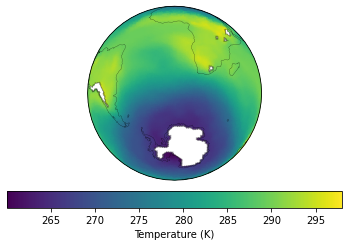

In [3]:

indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h0.2015-01.nc')
indir = os.path.expanduser('~/NetCDF_Files/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h0.2015-01.nc')
indir = os.path.expanduser('~/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc')


DS = xr.open_mfdataset(indir).chunk({'time': 20})
Tout = DS.PS.isel(time=0)
#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h2.2015-01-01-00000.nc')
#DS = xr.open_mfdataset(indir).chunk({'time': 20})
#Tout = DS.T850.isel(time=0)


Tin = DS.T
Tin = Tin.squeeze()
#print("Tin",Tin)
Pin = (DS.hyam*DS.P0 + DS.hybm*DS.PS)/100.
Pin.attrs["units"] = 'hPa'
Pin.attrs["long_name"] = 'Pressure'
Pin = Pin.squeeze()
pout = 850.

Tout2 = hy2plev(Tin, Pin, pout).squeeze()

# Read data
data = Tout2
print('plotting ', data)

lon = DS['lon']
lat = DS['lat']

dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=ccrs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)

tcoords = plotproj.transform_points(dataproj,np.array(lon[:]),np.array(lat[:]))
data2d = data
#xi=tcoords[:,0]!=np.inf  # cartopy versions switch between inf and nan for masked regions
xi = np.where(~(np.isnan(tcoords[:,0])|np.isinf(tcoords[:,0])))[0] # this works for either
tc=tcoords[xi,:]
datai=data2d[:][xi] # convert to numpy array, then subset
dmin = datai.min().values
dmax = datai.max().values
pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='gouraud',vmin=dmin,vmax=dmax) # looks good
#pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='flat') # looks bad
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
fig = plt.gcf()
varname = "test_tripcolor"
plotfile = '%s.pdf'%varname
fig.savefig(plotfile, bbox_inches='tight')
print('plotfile',plotfile)
plt.show()